In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Add a column to distinguish between train and test datasets
train_df['dataset'] = 'train'
test_df['dataset'] = 'test'

# Add a placeholder 'SalePrice' column to the test dataset
test_df['SalePrice'] = 0

# Concatenate the datasets
combined_df = pd.concat([train_df, test_df], ignore_index=True)

# Display the shape and first few rows of the combined dataset
print(combined_df.shape)
print(combined_df.head())


(2919, 82)
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolQC Fence MiscFeature MiscVal MoSold YrSold  \
0         Lvl    AllPub  ...    NaN   NaN         NaN       0      2   2008   
1         Lvl    AllPub  ...    NaN   NaN         NaN       0      5   2007   
2         Lvl    AllPub  ...    NaN   NaN         NaN       0      9   2008   
3         Lvl    AllPub  ...    NaN   NaN         NaN       0      2   2006   
4         Lvl    AllPub  ...    NaN   NaN         NaN       0     12   2008   

  SaleType  SaleCondition  SalePrice  dataset  
0       WD         No

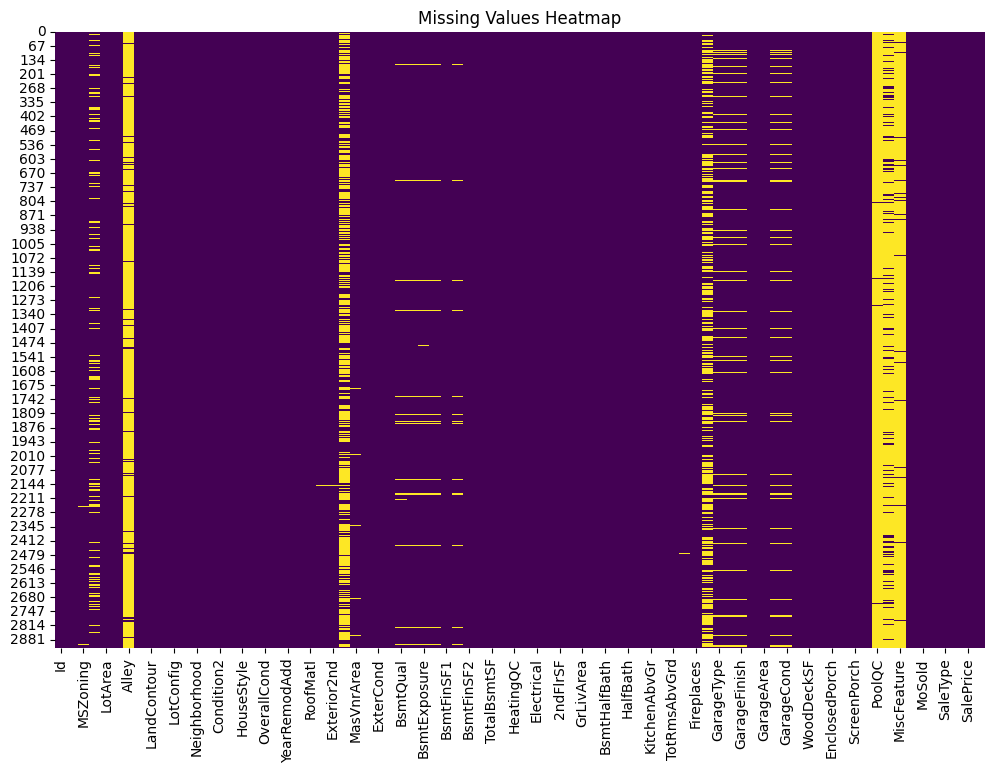

In [8]:
# Visualize missing values
plt.figure(figsize=(12, 8))
sns.heatmap(combined_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()


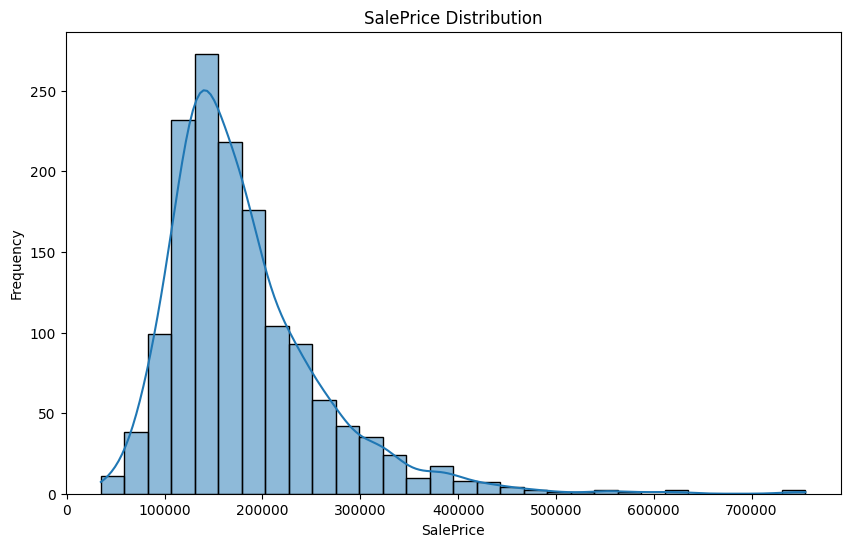

In [9]:
# Visualize the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(train_df['SalePrice'], kde=True, bins=30)
plt.title('SalePrice Distribution')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()


In [11]:
# Drop columns with a high percentage of missing values
combined_df.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], inplace=True)

# Fill missing values for numerical columns with the median
numerical_cols = combined_df.select_dtypes(include=['int64', 'float64']).columns
combined_df[numerical_cols] = combined_df[numerical_cols].fillna(combined_df[numerical_cols].median())

# Fill missing values for categorical columns with the mode
categorical_cols = combined_df.select_dtypes(include=['object']).columns
combined_df[categorical_cols] = combined_df[categorical_cols].fillna(combined_df[categorical_cols].mode().iloc[0])

# Verify that there are no more missing values
print(combined_df.isnull().sum().sum())


0


In [12]:
from scipy import stats
import numpy as np

# Remove outliers based on Z-score
z_scores = np.abs(stats.zscore(combined_df[numerical_cols].drop(columns=['Id', 'SalePrice'])))
filtered_entries = (z_scores < 3).all(axis=1)
combined_df = combined_df[filtered_entries]

# Display the shape of the dataset after removing outliers
print(combined_df.shape)


(2055, 77)


In [13]:
# One-hot encoding for categorical variables
combined_df = pd.get_dummies(combined_df)

# Display the first few rows after encoding
print(combined_df.head())


    Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0    1          60         65.0     8450            7            5       2003   
2    3          60         68.0    11250            7            5       2001   
4    5          60         84.0    14260            8            5       2000   
6    7          20         75.0    10084            8            5       2004   
10  11          20         70.0    11200            5            5       1965   

    YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  SaleType_Oth  SaleType_WD  \
0           2003       196.0       706.0  ...         False         True   
2           2002       162.0       486.0  ...         False         True   
4           2000       350.0       655.0  ...         False         True   
6           2005       186.0      1369.0  ...         False         True   
10          1965         0.0       906.0  ...         False         True   

    SaleCondition_Abnorml  SaleCondition_AdjLand  SaleCo

(1032, 253) (1032,) (1023, 254)
Mean Squared Error: 1.0646483484430005e+17


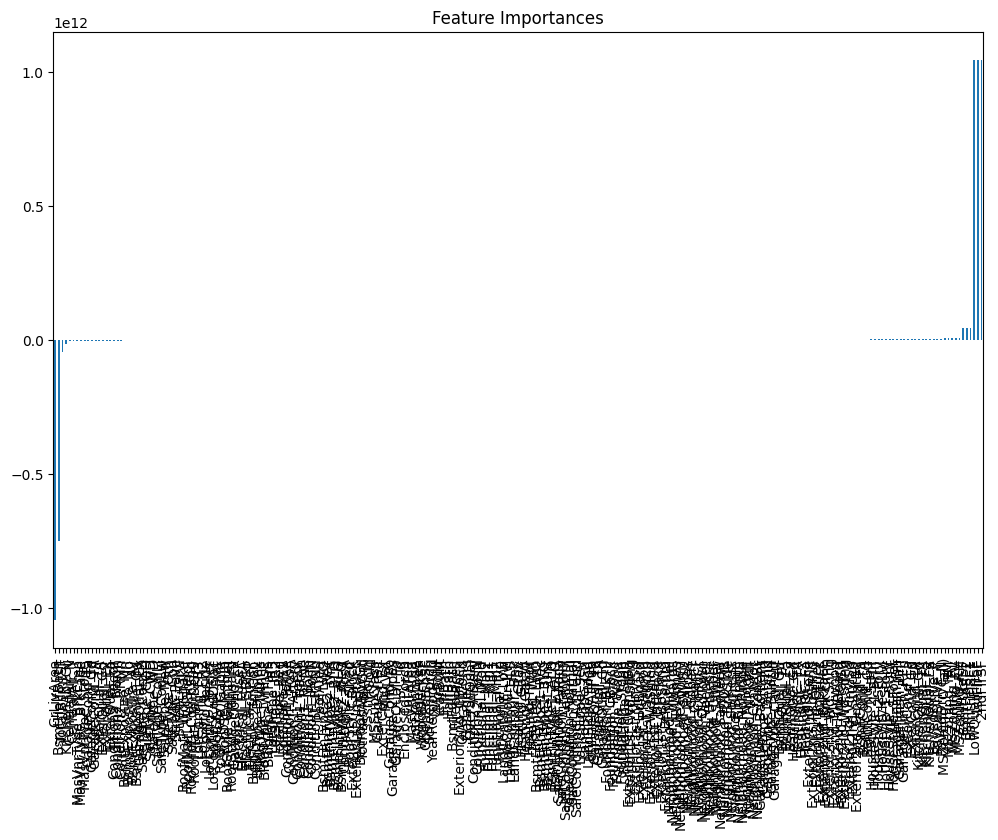

In [15]:
# Split the combined dataset back into train and test sets
train_df = combined_df[combined_df['dataset_train'] == 1].drop(['dataset_train', 'dataset_test'], axis=1)
test_df = combined_df[combined_df['dataset_test'] == 1].drop(['dataset_train', 'dataset_test'], axis=1)

# Separate features and target variable from training data
X = train_df.drop('SalePrice', axis=1)
y = train_df['SalePrice']

# Display the shapes of the final train and test sets
print(X.shape, y.shape, test_df.shape)

# Split the training data into training and validation sets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
importances = pd.Series(model.coef_, index=X.columns)

# Train a regression model
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the validation set
y_pred = model.predict(X_val)

# Calculate and print the Mean Squared Error
mse = mean_squared_error(y_val, y_pred)
print("Mean Squared Error:", mse)

# Visualize feature importances
importances = pd.Series(model.coef_, index=X.columns)
plt.figure(figsize=(12, 8))
importances.sort_values().plot(kind='bar')
plt.title('Feature Importances')
plt.show()


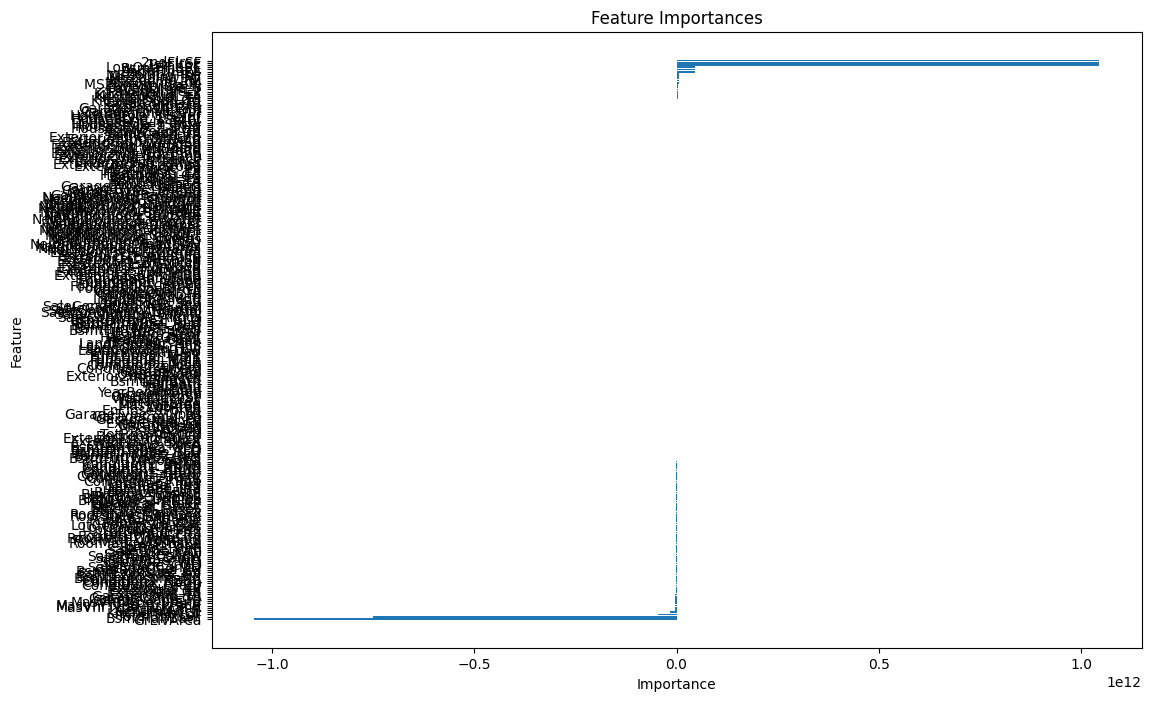

In [16]:
# Import necessary library
import matplotlib.pyplot as plt

# Calculate feature importances
importances = model.coef_

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort feature importances
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()
